In [179]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score


In [180]:
import torch

print("Is CUDA available: ", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)
print("Number of CUDA devices: ", torch.cuda.device_count())
print("CUDA Device Name: ", torch.cuda.get_device_name(0) if torch.cuda.device_count() > 0 else "No CUDA device")


Is CUDA available:  True
CUDA version:  12.1
Number of CUDA devices:  1
CUDA Device Name:  Tesla T4


In [181]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [182]:
row_data_file = 'TSLA_stock_data_2023.csv'
predict_data_file = 'TSLA_stock_data_2024.csv'

In [183]:
# Creating sliding windows
def slide_windows(features):

    # We need to ensure we have data for t-1, t, t+1 without index errors
    windowed_data = []
    predict_prices = []  # List to store the target 'Close' prices
    cycle_data=[]

    # Handling daily cycles
    cycle_length = 7
    for cycle in range(len(features) - cycle_length + 1):
        start_index = cycle
        end_index = start_index + cycle_length
        cycle_datas = features.iloc[start_index:end_index,1:6].values
        cycle_data.append(cycle_datas)

    # Creating sliding windows within the cycle
    for i in range(14,len(cycle_data)-7):  # Avoiding index error by stopping before the last day
        pre_previous = cycle_data[i - 14]
        previous = cycle_data[i- 7]
        current_state = cycle_data[i]

        combined_features = np.concatenate([pre_previous, previous, current_state]).reshape(1,-1).squeeze()
        windowed_data.append(combined_features)
        predict_prices.append(cycle_data[i+7][-1][3])

    return windowed_data, predict_prices


In [184]:
# Load data
row_data = pd.read_csv(row_data_file)

windowed_data, predict_prices = slide_windows(row_data)
# Convert to PyTorch tensors
state = torch.tensor(windowed_data, dtype=torch.float32).to(device)
predict_price = torch.tensor(predict_prices, dtype=torch.float32).to(device)
# state[0]

predict_price[0]

tensor(113.0300, device='cuda:0')

In [185]:
# divide the data into training part and test part
state_train, state_test, predict_price_train,predict_price_test= train_test_split(state, predict_price,test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(state_train, predict_price_train), batch_size=200, shuffle=True)
test_loader = DataLoader(TensorDataset(state_test, predict_price_test), batch_size=300)
len(train_loader)


7

In [186]:
# construct NN
class NN(nn.Module):
    def __init__(self, n_observations):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


In [187]:
# Optimazation function, it do one step of gredient decent,
def optimize_model():
    for state, target in train_loader:
        current_value=value_net(state).squeeze()
        criterion = nn.SmoothL1Loss()
        loss=criterion(current_value,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    for state, target in test_loader:
        with torch.no_grad():
            test_valur=value_net(state).squeeze()
            l_test=criterion(test_valur,target)
    return loss.item(),l_test.item()

In [202]:
learning_rates = [1e-3]  # Possible learning rates
weight_decays = [1e-2]  # Possible weight decay values
n_observations = len(state[0])
epochs=1000

best_lr = None
best_weight_decay = None
lowest_test_loss = float('inf')  # Initialize with infinity to ensure any first result is better

# value_net is your prediction function, take state as input and output is the prediction price
value_net = NN(n_observations).to(device)

for LR in learning_rates:
    for wd in weight_decays:
        print(f"Testing with LR = {LR} and Weight Decay = {wd}")
        # 'optimize'  is an easy package to do Gredient decent, 'Adam' is a method to let learing rate decay as step go.
        optimizer = optim.Adam(value_net.parameters(), lr=LR,weight_decay=wd)

        # Run the training loop for this combination of parameters
        for epoch in range(epochs):
            l_train, l_test = optimize_model()  # Use the current lr and wd in your optimization
            if epoch % 100 == 0:  # Report every 100 epochs
                print(f'Epoch [{epoch+1}/{epochs}], L_train: {l_train}, L_test: {l_test}')

            # Save parameters if this is the best we've seen
            if l_test < lowest_test_loss:
                lowest_test_loss = l_test
                best_lr = LR
                best_weight_decay = wd

# Output the best parameters and the test loss achieved with them
print(f"Best Learning Rate: {best_lr}, Best Weight Decay: {best_weight_decay}, Lowest L_test: {lowest_test_loss}")
#

Testing with LR = 0.001 and Weight Decay = 0.01
Epoch [1/1000], L_train: 162461.265625, L_test: 276378.8125
Epoch [101/1000], L_train: 29093.708984375, L_test: 22728.095703125
Epoch [201/1000], L_train: 5718.72265625, L_test: 9528.4375
Epoch [301/1000], L_train: 7027.38671875, L_test: 7680.0390625
Epoch [401/1000], L_train: 2199.861083984375, L_test: 5758.205078125
Epoch [501/1000], L_train: 1447.7686767578125, L_test: 3436.920166015625
Epoch [601/1000], L_train: 1023.7678833007812, L_test: 2589.6552734375
Epoch [701/1000], L_train: 664.7922973632812, L_test: 2153.30517578125
Epoch [801/1000], L_train: 1064.9866943359375, L_test: 1575.3363037109375
Epoch [901/1000], L_train: 251.06939697265625, L_test: 826.0755615234375
Best Learning Rate: 0.001, Best Weight Decay: 0.01, Lowest L_test: 352.7765197753906


In [243]:
# continue optimize
# start from last training result
epochs=1000
LR = 1e-15
Weight_decay=0.01
optimizer = optim.Adam(value_net.parameters(), lr=LR,weight_decay=Weight_decay)
value_net.train()

run_count = 0

# while True:
for epoch in range(epochs):
    l_train, l_test = optimize_model()
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], L_train: {l_train}, L_test: {l_test}')
    # Save parameters if this is the best we've seen
    if l_test < lowest_test_loss:
        lowest_test_loss = l_test
        torch.save(value_net.state_dict(),'model_parameters.pth')
        print("store result from ",f'Epoch [{epoch+1}/{epochs}], L_train: {l_train}, L_test: {l_test}')
    # run_count += 1

    # # Check the stopping condition
    # if l_test <= 10 or run_count > 2:
    #     print("Stopping the loop.")
    #     break
print(f"lowest L_test: {lowest_test_loss}")

Epoch [1/1000], L_train: 7.428871154785156, L_test: 6.81044340133667
Epoch [11/1000], L_train: 7.774215221405029, L_test: 6.810653209686279
Epoch [21/1000], L_train: 7.447015762329102, L_test: 6.810847759246826
Epoch [31/1000], L_train: 6.522643089294434, L_test: 6.811068534851074
Epoch [41/1000], L_train: 7.666537761688232, L_test: 6.811191082000732
Epoch [51/1000], L_train: 7.174262523651123, L_test: 6.811415672302246
Epoch [61/1000], L_train: 7.446533203125, L_test: 6.811594486236572
Epoch [71/1000], L_train: 7.117514133453369, L_test: 6.811761379241943
Epoch [81/1000], L_train: 7.619330883026123, L_test: 6.811946392059326
Epoch [91/1000], L_train: 7.071984767913818, L_test: 6.812095642089844
Epoch [101/1000], L_train: 7.522940635681152, L_test: 6.812171936035156
Epoch [111/1000], L_train: 7.255618095397949, L_test: 6.8123779296875
Epoch [121/1000], L_train: 7.801272392272949, L_test: 6.812464714050293
Epoch [131/1000], L_train: 7.210257053375244, L_test: 6.812559604644775
Epoch [14

In [244]:
# # load the trained parameter to the model
loaded_model = NN(n_observations).to(device)
loaded_model.load_state_dict(torch.load('model_parameters.pth'))
value_net=loaded_model

<All keys matched successfully>

In [245]:
# Load data to predict
windowed_data, predict_prices = slide_windows(pd.read_csv(predict_data_file))
# Convert to PyTorch tensors
state_new = torch.tensor(windowed_data, dtype=torch.float32).to(device)
real_price = torch.tensor(predict_prices, dtype=torch.float32).to(device)

l_test =[]
predict_price=[]
replace = 0
n=0
# predict price
value_net.eval()
with torch.no_grad():
    criterion = nn.SmoothL1Loss()
    predict_price=loaded_model(state_new).squeeze() #predict price
    adjusted_predict_price = predict_price.clone()

    # Calculate the difference for each hour
    for i in range(real_price.size(0)):  # Assuming real_price and predict_price are of the same length
        # Calculate loss for each pair
        loss = criterion(real_price[i], predict_price[i])

        # Check if loss is greater than 15, replace predicted price with real price if condition is met
        if loss.item() > 15:
            predict_price[i] = real_price[i-7]
            replace += 1
        n+=1
        loss = criterion(real_price[i], predict_price[i])
        l_test.append(loss.item())

# print(predict_price)
print(l_test)
# print(state_new)
print(replace,n)

[87.41099548339844, 86.489990234375, 89.58999633789062, 89.80450439453125, 90.70999145507812, 92.08489990234375, 93.18800354003906, 2.449005126953125, 4.125, 3.47979736328125, 3.7895050048828125, 4.275390625, 5.401092529296875, 5.4239044189453125, 5.00030517578125, 0.24851378798484802, 1.2021026611328125, 1.720001220703125, 0.22848454117774963, 0.2055620402097702, 0.5841064453125, 0.4897533655166626, 4.5762939453125, 6.073089599609375, 6.4618988037109375, 6.3336029052734375, 7.10009765625, 4.9720001220703125, 6.0847015380859375, 5.833709716796875, 3.71990966796875, 6.5630950927734375, 6.8700103759765625, 8.659896850585938, 9.237594604492188, 7.98529052734375, 0.8400115966796875, 0.06990111619234085, 0.06301098316907883, 1.4267120361328125, 1.779998779296875, 0.5991058349609375, 0.6786956787109375, 9.270004272460938, 7.5861968994140625, 4.4449920654296875, 7.901611328125, 5.6699981689453125, 4.9945068359375, 3.958709716796875, 0.6100006103515625, 0.8600006103515625, 2.94500732421875, 3.

In [246]:
real_price_data = real_price.cpu().numpy()
predict_price_data = predict_price.cpu().numpy()

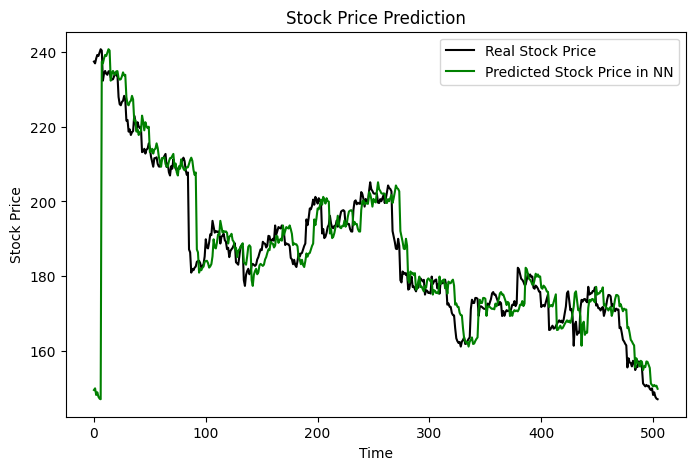

In [247]:
plt.figure(figsize=(8, 5))
plt.plot(real_price_data, color='black', label='Real Stock Price')
plt.plot(predict_price_data, color='green', label='Predicted Stock Price in NN')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

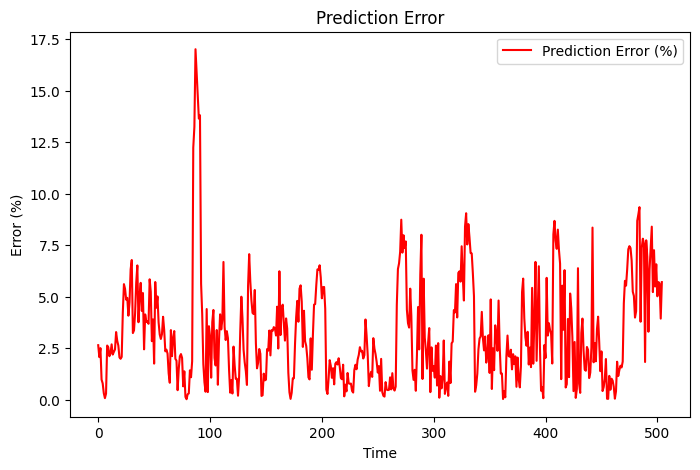

In [240]:
plt.figure(figsize=(8, 5))
calculate = np.abs((real_price_data - predict_price_data) / real_price_data) * 100
plt.plot(calculate, color='red', label='Prediction Error (%)')
plt.title('Prediction Error')
plt.xlabel('Time')
plt.ylabel('Error (%)')
plt.legend()
plt.show()

In [241]:
r2 = r2_score(real_price_data, predict_price_data)

print(f"Average NN Prediction Error (%): {np.mean(calculate)}")
print(f"Variance of NN Prediction Error (%): {np.var(calculate)}")
print(f"R^2 Score: {r2}")

Average NN Prediction Error (%): 3.2021145820617676
Variance of NN Prediction Error (%): 6.525866508483887
R^2 Score: 0.8567762769544889
